<a href="https://colab.research.google.com/github/ohashi-gnct/exp/blob/2023/E_%E7%82%BA%E6%9B%BF%E3%81%AE%E8%A7%A3%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

この課題を行う際は、最低限以下の項目を学習すること。

- 円安・円高とはどのような状態か
- CPI（消費者物価指数）とは何か
- 利回りとは何か
- 国債利回りには経済的にどのような意味があるか


In [1]:
import os
import io
import json
import datetime as dt

import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

Colabに最初から入っていないライブラリをUNIXコマンドの`pip`で導入する。

`japanize-matplotlib`は日本語でmatplotlibが使えるようにするライブラリである。

In [ ]:
!pip install japanize-matplotlib

In [3]:
# matplotlibの日本語化
import japanize_matplotlib
%matplotlib inline
sns.set(font="IPAexGothic")

Googleドライブを接続し、CSVファイルを自分のドライブに保存する。

認証を求める画面が出る場合がある。

自身でJupyter notebook環境を作っている場合、ディレクトリは適当に読み替えること。

In [ ]:
# Googleドライブの接続
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
drive_path = '/content/drive/MyDrive'

プロットの見栄えがするように初期設定する。

In [5]:
# matplotlibの初期設定
plt_config = {
    "figure.dpi": 150,
    "font.size": 14,
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "mathtext.cal": "serif",
    "mathtext.rm": "serif",
    "mathtext.it": "serif:italic",
    "mathtext.bf": "serif.bold",
    "mathtext.fontset": "cm",
    "legend.framealpha": 1.0,
    "legend.edgecolor": "black",
    "legend.fancybox": False
}
plt.rcParams.update(plt_config)

# 日本の消費者物価指数

e-Statから月次の消費者物価指数をダウンロードしたものが以下にアップロードされている。

https://www.gifu-nct.ac.jp/elec/ohashi/datascience/japan_cpi.csv

このCSVは以下のページで取得できる。

https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200573&tstat=000001150147&cycle=0&tclass1=000001150151&tclass2=000001150152&tclass3=000001150153&tclass4=000001150156&stat_infid=000032103842&tclass5val=0

UNIXコマンド`curl`でGoogleドライブにファイルをダウンロードする。



In [ ]:
!curl -o /content/drive/MyDrive/japan_cpi.csv https://www.gifu-nct.ac.jp/elec/ohashi/datascience/japan_cpi.csv


今回は、消費者物価指数の中でも

- 総合（CPI）
- 食料（酒類を除く）及びエネルギーを除く総合（コアコアCPI）

を使用する。

In [ ]:
df_japan_cpi = pd.read_csv(os.path.join(drive_path, "japan_cpi.csv"),
                           names=("date", "日本CPI", "日本コアコアCPI"),
                           usecols=[0, 1, 6], skiprows=6,
                           encoding="SHIFT-JIS")
df_japan_cpi["date"] = pd.to_datetime(df_japan_cpi["date"], format='%Y%m')
df_japan_cpi = df_japan_cpi.set_index("date")
df_japan_cpi

In [ ]:
df_japan_cpi.plot()

# アメリカ消費者物価指数

アメリカ Bureau of Labor Statistics から月次の消費者物価指数をダウンロードしたものが以下にアップロードされている。



これらのCSVは以下のページから取得できる。

All items in U.S. city average, all urban consumers, not seasonally adjusted

https://beta.bls.gov/dataViewer/view/timeseries/CUUR0000SA0

All items less food and energy in U.S. city average, all urban consumers, not seasonally adjusted

https://beta.bls.gov/dataViewer/view/timeseries/CUUR0000SA0L1E

利用規約を下に示す。

https://www.bls.gov/developers/termsOfService.htm

UNIXコマンド`curl`でGoogleドライブにファイルをダウンロードする。

In [ ]:
!curl -o /content/drive/MyDrive/us_cpi_allitems.csv https://www.gifu-nct.ac.jp/elec/ohashi/datascience/us_cpi_allitems.csv
!curl -o /content/drive/MyDrive/us_cpi_lessfoodenergy.csv https://www.gifu-nct.ac.jp/elec/ohashi/datascience/us_cpi_lessfoodenergy.csv

In [ ]:
df_us_cpi_allitems = pd.read_csv(os.path.join(drive_path, "us_cpi_allitems.csv"),
                                 names=("Year", "Period", "米国CPI"),
                                 usecols=[1, 2, 4], skiprows=1)
df_us_cpi_lessfoodenergy = pd.read_csv(os.path.join(drive_path, "us_cpi_lessfoodenergy.csv"),
                                       names=("Year", "Period", "米国コアコアCPI"),
                                       usecols=[1, 2, 4], skiprows=1)

# 'Year' と 'Period' をキーとして結合
df_us_cpi = pd.merge(df_us_cpi_allitems, df_us_cpi_lessfoodenergy, on=['Year', 'Period'], how='inner')

# 'Year'と'Period'から日付を作成
df_us_cpi['date'] = pd.to_datetime(df_us_cpi['Year'].astype(str) + '-' + df_us_cpi['Period'].str[1:])
df_us_cpi = df_us_cpi[['date', '米国CPI', '米国コアコアCPI']]

df_us_cpi = df_us_cpi.set_index("date")

df_us_cpi

In [ ]:
df_us_cpi.plot()

# 日本の物価連動国債利回り

浜町SCIが公表している7年もの物価連動国債の流通利回りを使用する。

このデータについては各自でダウンロードすること。使用しなくてもよい。

https://www.hamacho.net/jp/data/%e5%9b%bd%e5%82%b5%e3%81%ae%e6%b5%81%e9%80%9a%e5%88%a9%e5%9b%9e%e3%82%8a%e3%81%ae%e6%99%82%e7%b3%bb%e5%88%97%e3%83%87%e3%83%bc%e3%82%bf/

In [ ]:
df_japan_yield_ip_bond = pd.read_csv(os.path.join(drive_path, "TIPS-202310 - CSV.csv"),
                                 names=("date", "日本物価連動国債利回り"),
                                 usecols=[0, 8], skiprows=70)
df_japan_yield_ip_bond["date"] = pd.to_datetime(df_japan_yield_ip_bond["date"], format='%Y%m')
df_japan_yield_ip_bond = df_japan_yield_ip_bond.set_index("date")
df_japan_yield_ip_bond

In [ ]:
df_japan_yield_ip_bond.plot()

# アメリカ物価連動国債利回り

FRBが公表しているものをFREDが編集した、7年もの物価連動国債の流通利回りを使用する。

このデータについては各自でダウンロードすること。使用しなくてもよい。

https://fred.stlouisfed.org/series/FII7

In [ ]:
df_us_yield_ip_bond = pd.read_csv(os.path.join(drive_path, "FII7.csv"),
                                 names=("date", "米国物価連動国債利回り"), skiprows=1)
df_us_yield_ip_bond["date"] = pd.to_datetime(df_us_yield_ip_bond["date"])
df_us_yield_ip_bond = df_us_yield_ip_bond.set_index("date")
df_us_yield_ip_bond

In [ ]:
df_us_yield_ip_bond.plot()

# ドル円為替相場

日本銀行から月ごとの為替相場をダウンロードしたものが以下にアップロードされている。

https://www.gifu-nct.ac.jp/elec/ohashi/datascience/usd_jpy.csv

このCSVは以下のページで取得できる。

https://www.stat-search.boj.or.jp/ssi/mtshtml/fm08_m_1.html

注意：これは名目為替レートである。実質為替レートは消費者物価指数を使って算出できる。

UNIXコマンド`curl`でGoogleドライブにファイルをダウンロードする。


In [ ]:
!curl -o /content/drive/MyDrive/usd_jpy.csv https://www.gifu-nct.ac.jp/elec/ohashi/datascience/usd_jpy.csv

今回は東京市場　ドル・円　スポット　17時時点/月末	のデータを使う。

In [ ]:
df_usd_jpy = pd.read_csv(os.path.join(drive_path, "usd_jpy.csv"),
                         names=("date", "ドル円"),
                         usecols=[0, 1], skiprows=9,
                         encoding="SHIFT-JIS")

df_usd_jpy["date"] = pd.to_datetime(df_usd_jpy["date"], format='%Y/%m')
df_usd_jpy = df_usd_jpy.set_index("date")
df_usd_jpy

In [ ]:
df_usd_jpy.plot()

# 日米金利差

物価連動でない10年もの国債の金利差を計算する。

日本の国債利回り：

https://www.mof.go.jp/jgbs/reference/interest_rate/index.htm

アメリカの国債利回り：

https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics

非常に手間がかかるため、今回は加工したデータを用意したので、これを使用する。

https://www.gifu-nct.ac.jp/elec/ohashi/datascience/usd_jpy.csv

In [ ]:
!curl -o /content/drive/MyDrive/us_japan_yield.csv https://www.gifu-nct.ac.jp/elec/ohashi/datascience/us_japan_yield.csv

In [ ]:
df_yield_bond = pd.read_csv(os.path.join(drive_path, "us_japan_yield.csv"),
                            names=("date", "米国国債利回り", "日本国債利回り"),
                            skiprows=1)
df_yield_bond['日米金利差'] = df_yield_bond['米国国債利回り'] - df_yield_bond['日本国債利回り']
df_yield_bond["date"] = pd.to_datetime(df_yield_bond["date"])
df_yield_bond = df_yield_bond.set_index("date")
df_yield_bond

In [ ]:
df_yield_bond.plot()

# 相関関係の分析

上のデータから任意の2データを選び、相関関係を分析する。

まずはDataFrameを結合する。

`index`つまり`date`が共通の列だけを結合した新たなDataFrameを作る。



**データフレーム一覧**

日本の消費者物価指数：`df_japan_cpi`

アメリカ消費者物価指数：`df_us_cpi`

日本の物価連動国債利回り：`df_japan_yield_ip_bond`

アメリカ物価連動国債利回り：`df_us_yield_ip_bond`

ドル円為替相場：`df_usd_jpy`

日米金利差：`df_yield_bond`

ここでは、日米金利差と為替の関係を分析する。

In [ ]:
# 2つのdfでindexが共通の列だけを結合する
df_merged = pd.merge(df_usd_jpy, df_yield_bond, on='date', how="inner").dropna()
df_merged

特定の期間だけに着目する場合は、そのデータを切り出す。

In [27]:
# 特定の期間を切り出す
df_filtered = df_merged.loc['2020-01-01':'2023-09-01']
df_filtered

,ドル円,米国国債利回り,日本国債利回り,日米金利差
date,,,,
2020-01-01,109.04,1.717143,0.009000,1.708143
2020-03-01,108.42,0.872308,0.040750,0.831558
2020-04-01,106.60,0.644286,0.011167,0.633119
2020-05-01,107.21,0.673333,0.006385,0.666949
2020-06-01,107.73,0.695833,0.025409,0.670424
2020-07-01,104.45,0.604667,0.025381,0.579286
2020-08-01,105.83,0.690769,0.038300,0.652469
2020-09-01,105.62,0.679231,0.032900,0.646331
2020-10-01,104.36,0.802143,0.029773,0.772370


それぞれの変数をプロットしてみる。

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

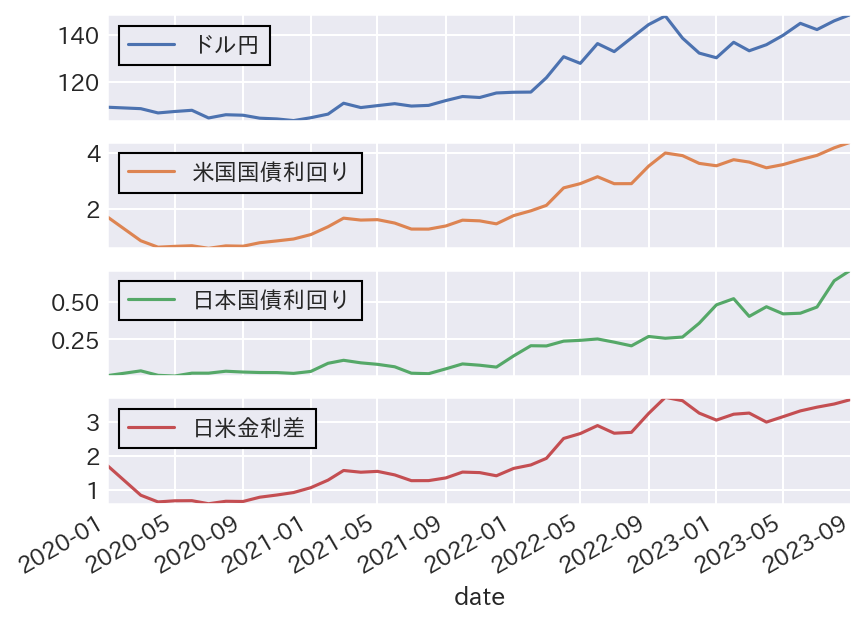

In [28]:
df_filtered.plot(subplots=True)

グラフを見ると、コロナ禍では日米金利差の拡大と円安は同じように進行していると考えられる。

matplotlibのラッパーである`seaborn`ライブラリを使って、

すべての組み合わせの2変数で散布図を作成できる。

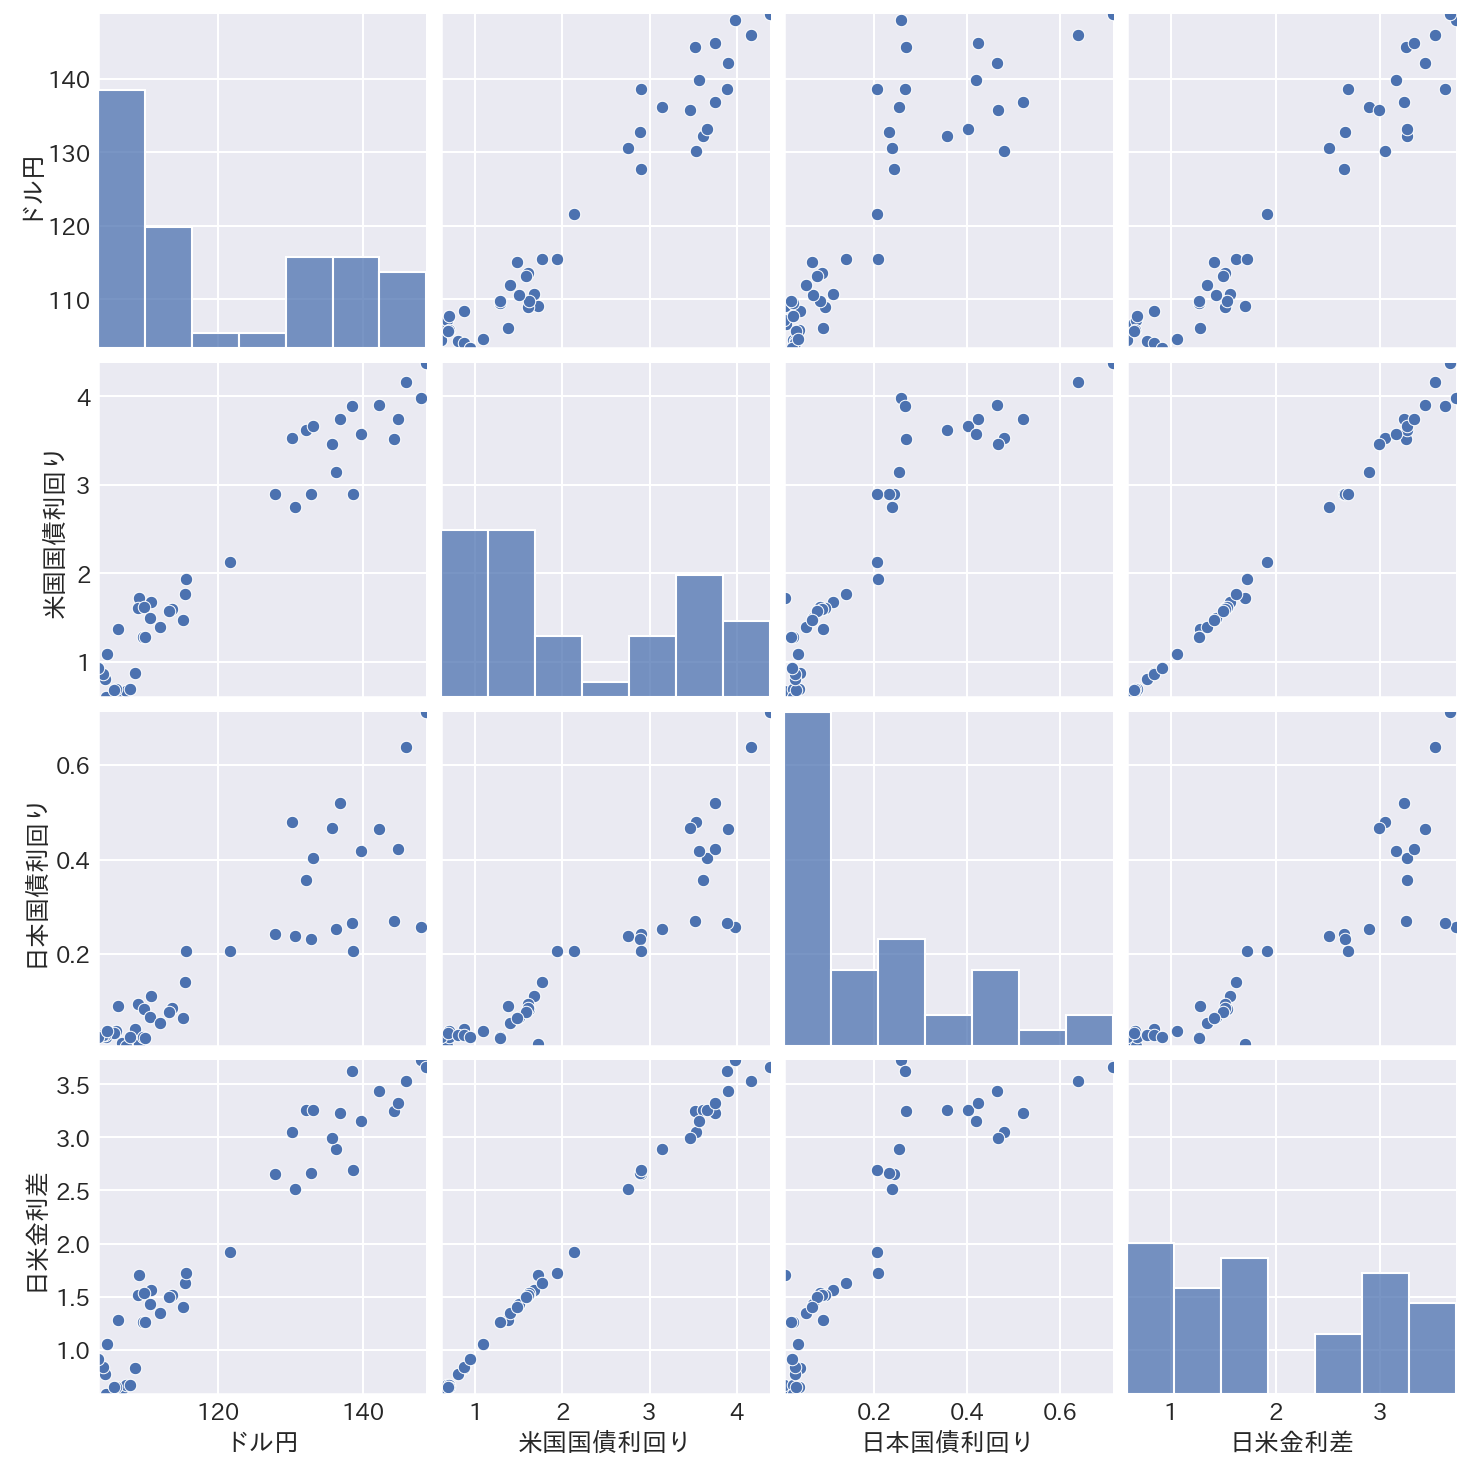

In [29]:
sns.pairplot(df_filtered)

散布図を描くことで、2変数がどのように関係しているか直感的に確認できる。

この図をもとに考察してもよい。

これらの相関係数を求める。

3変数以上ある場合にも、相互に相関係数を求められる。

<Axes: >

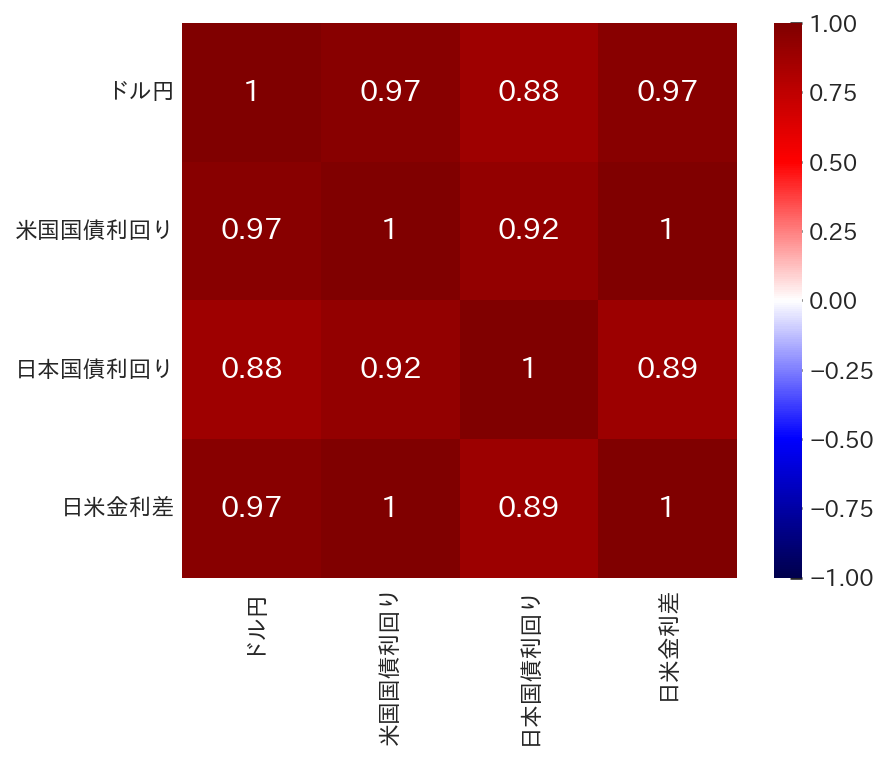

In [30]:
corr = df_filtered.corr()
sns.heatmap(corr, vmax=1, vmin=-1, center=0,
            cmap="seismic", square=True, annot=True)

今回は日米金利差`yield_difference`とドル円`usd_jpy`の関係に着目する。

一般的には、金利が低い通貨は通貨安になりやすい。

# 単回帰分析

任意の1変数を目的変数(y軸)、別の任意の1変数を説明変数(x軸)として、

単回帰分析を行う。

まず、機械学習のためのライブラリscikit-learnから

単回帰分析のためのモジュールを読み込む。

In [31]:
from sklearn import linear_model

In [32]:
clf = linear_model.LinearRegression()
X = df_filtered[["日米金利差"]]
Y = df_filtered[["ドル円"]]
clf.fit(X, Y)

print("回帰係数: " + str(clf.coef_))
print("切片: " + str(clf.intercept_))
print("決定係数: " + str(clf.score(X, Y)))

回帰係数: [[13.93910301]]
切片: [93.31195702]
決定係数: 0.9352208284850577


決定係数が高いため、日米の金利差によって日米為替レートの変化のうち大部分を説明できることがわかる。

ただし、2020年以降のデータのみを使用していることに注意が必要である。

回帰直線を散布図に重ねて描くと以下のようになる。

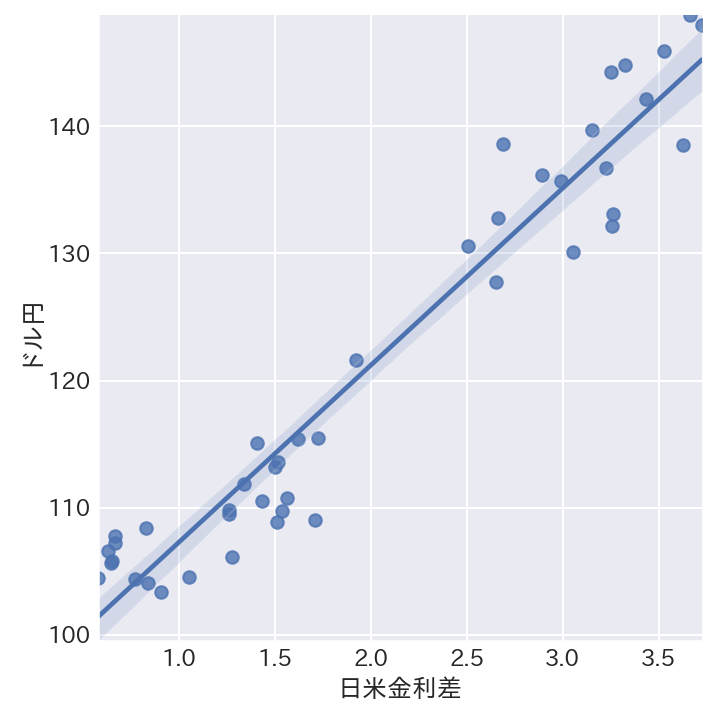

In [34]:
sns.lmplot(x="日米金利差", y="ドル円", data=df_filtered)

グラフからも、単回帰によって十分に目的変数を説明していることがわかる。